In [57]:
import tensorflow as tf
import src
from keras import layers, models
from keras.layers import (
    Conv2D,
    Flatten,
    Dense,
    MaxPooling2D,
)
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from src.labels_maps import fine_id_coarse_id

In [3]:
fine_train, fine_val, fine_test = src.load_preprocessed_datasets(label_mode="fine")
coarse_train, coarse_val, coarse_test = src.load_preprocessed_datasets(
    label_mode="coarse"
)


augment_layer = tf.keras.Sequential(
    [
        layers.RandomFlip(mode="horizontal"),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomRotation(0.2),
    ]
)


@tf.function
def augment_images(image, label):
    return (augment_layer(image), label)


fine_train = fine_train.map(augment_images)
coarse_train = coarse_train.map(augment_images)

In [4]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    sns.lineplot(
        {
            "loss": history.history["loss"],
            "val_loss": history.history["val_loss"],
        },
        ax=ax1,
    )
    sns.lineplot(
        {
            "accuracy": history.history["accuracy"],
            "val_accuracy": history.history["val_accuracy"],
        },
        ax=ax2,
    )

## Проверка LeNet

In [5]:
def build_lenet_model(num_classes, model_name):
    model = models.Sequential(name=model_name)
    model.add(
        Conv2D(
            6,
            (5, 5),
            padding="valid",
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=(32, 32, 3),
        )
    )
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(
        Conv2D(
            16,
            (5, 5),
            padding="valid",
            activation="relu",
            kernel_initializer="he_normal",
        )
    )
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(120, activation="relu", kernel_initializer="he_normal"))
    model.add(Dense(84, activation="relu", kernel_initializer="he_normal"))
    model.add(Dense(num_classes, activation="softmax", kernel_initializer="he_normal"))

    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=0.0001),
        metrics=["accuracy"],
    )

    return model

In [11]:
lenet_coarse_model = build_lenet_model(20, "lenet_coarse")
lenet_fine_model = build_lenet_model(100, "lenet_fine")

In [12]:
early_stop = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=4, restore_best_weights=True
)

lenet_coarse_history = lenet_coarse_model.fit(
    coarse_train, epochs=30, validation_data=coarse_val, callbacks=[early_stop]
)

Epoch 1/30
625/625 [==============================] - 9s 14ms/step - loss: 2.9315 - accuracy: 0.1106 - val_loss: 2.7769 - val_accuracy: 0.1576
Epoch 2/30
625/625 [==============================] - 8s 12ms/step - loss: 2.7285 - accuracy: 0.1646 - val_loss: 2.6642 - val_accuracy: 0.1920
Epoch 3/30
625/625 [==============================] - 9s 14ms/step - loss: 2.6489 - accuracy: 0.1884 - val_loss: 2.5914 - val_accuracy: 0.2149
Epoch 4/30
625/625 [==============================] - 9s 14ms/step - loss: 2.5879 - accuracy: 0.2098 - val_loss: 2.5394 - val_accuracy: 0.2319
Epoch 5/30
625/625 [==============================] - 8s 13ms/step - loss: 2.5388 - accuracy: 0.2227 - val_loss: 2.5024 - val_accuracy: 0.2437
Epoch 6/30
625/625 [==============================] - 9s 14ms/step - loss: 2.5100 - accuracy: 0.2319 - val_loss: 2.4741 - val_accuracy: 0.2523
Epoch 7/30
625/625 [==============================] - 8s 13ms/step - loss: 2.4785 - accuracy: 0.2433 - val_loss: 2.4532 - val_accuracy: 0.2599

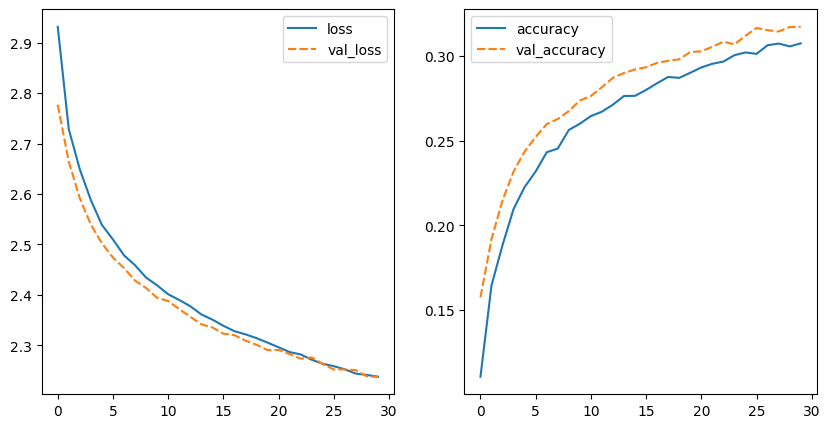

In [13]:
plot_history(lenet_coarse_history)

In [15]:
early_stop = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=4, restore_best_weights=True
)

lenet_fine_history = lenet_fine_model.fit(
    fine_train, epochs=30, validation_data=fine_val, callbacks=[early_stop]
)

Epoch 1/30
625/625 [==============================] - 10s 15ms/step - loss: 4.6556 - accuracy: 0.0161 - val_loss: 4.5524 - val_accuracy: 0.0267
Epoch 2/30
625/625 [==============================] - 8s 13ms/step - loss: 4.4507 - accuracy: 0.0361 - val_loss: 4.3649 - val_accuracy: 0.0465
Epoch 3/30
625/625 [==============================] - 8s 13ms/step - loss: 4.2658 - accuracy: 0.0586 - val_loss: 4.2085 - val_accuracy: 0.0682
Epoch 4/30
625/625 [==============================] - 8s 13ms/step - loss: 4.1349 - accuracy: 0.0765 - val_loss: 4.0965 - val_accuracy: 0.0838
Epoch 5/30
625/625 [==============================] - 8s 13ms/step - loss: 4.0552 - accuracy: 0.0870 - val_loss: 4.0259 - val_accuracy: 0.0969
Epoch 6/30
625/625 [==============================] - 9s 14ms/step - loss: 3.9925 - accuracy: 0.0932 - val_loss: 3.9720 - val_accuracy: 0.1047
Epoch 7/30
625/625 [==============================] - 9s 14ms/step - loss: 3.9346 - accuracy: 0.1042 - val_loss: 3.9197 - val_accuracy: 0.113

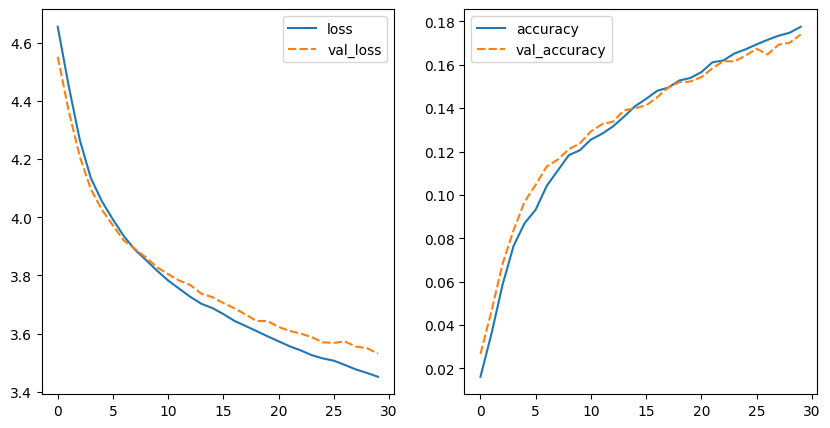

In [16]:
plot_history(lenet_fine_history)

In [59]:
coarse_df = pd.DataFrame(coarse_test.unbatch().as_numpy_iterator())

coarse_X = np.array(coarse_df.iloc[:, 0].tolist())
coarse_y_true = np.argmax(np.array(coarse_df.iloc[:, 1].tolist()), axis=1)

coarse_y_predicted = np.argmax(lenet_coarse_model.predict(coarse_X), axis=1)
print(
    "Classification Report:\n", classification_report(coarse_y_true, coarse_y_predicted)
)

313/313 [==============================] - 0s 678us/step
Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.35      0.35       500
           1       0.38      0.20      0.26       500
           2       0.53      0.61      0.57       500
           3       0.32      0.18      0.23       500
           4       0.38      0.39      0.39       500
           5       0.21      0.30      0.25       500
           6       0.26      0.22      0.24       500
           7       0.36      0.36      0.36       500
           8       0.19      0.43      0.27       500
           9       0.41      0.46      0.44       500
          10       0.69      0.43      0.53       500
          11       0.25      0.26      0.25       500
          12       0.23      0.32      0.27       500
          13       0.18      0.05      0.08       500
          14       0.36      0.38      0.37       500
          15       0.16      0.07      0.10       500


In [62]:
fine_test_df = pd.DataFrame(fine_test.unbatch().as_numpy_iterator())

fine_X = np.array(fine_test_df.iloc[:, 0].tolist())
fine_y_true = np.argmax(np.array(fine_test_df.iloc[:, 1].tolist()), axis=1)
fine_y_true = [fine_id_coarse_id[id] for id in fine_y_true]


fine_y_predicted = np.argmax(lenet_fine_model.predict(fine_X), axis=1)
fine_y_predicted = [fine_id_coarse_id[id] for id in fine_y_predicted]

print("Classification Report:\n", classification_report(fine_y_true, fine_y_predicted))

313/313 [==============================] - 0s 646us/step
Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.27      0.31       500
           1       0.40      0.23      0.29       500
           2       0.50      0.51      0.51       500
           3       0.31      0.13      0.19       500
           4       0.41      0.39      0.40       500
           5       0.18      0.26      0.21       500
           6       0.28      0.22      0.24       500
           7       0.37      0.29      0.32       500
           8       0.17      0.31      0.22       500
           9       0.39      0.38      0.38       500
          10       0.56      0.34      0.42       500
          11       0.27      0.22      0.24       500
          12       0.19      0.30      0.24       500
          13       0.22      0.13      0.17       500
          14       0.42      0.20      0.27       500
          15       0.13      0.17      0.15       500


Как мы видим разница в качестве предсказаний не значительна, но вероятно это связано с низким качеством предсказания LeNet на датасете Cifar-100. 

Поэтому нужно построить модель по-лучше для оценки